<a href="https://colab.research.google.com/github/MOISECHRIST/Machine-Learning/blob/main/TP2_INF372_MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 INF372 : APPRENTISSAGE SUPERVISE ET NON SUPERVISE

## Membre du groupe :
- FOSSI TALLA JORDANE (20U2878)
- MAKOU FOKOUA PATRICIA (21T2446)
- MEKA MOISE CHRISTIAN JUNIOR (21T2561)
- RUDY TCHAMBA TCHAPTCHE ITIEL (21T2981)

## Objectif du TP

Il s'agit d'implémenter un MLP (MultiLayer Perceptron) sur l’ensemble de données sur l’apparition du diabète chez les Indiens Pima. L'idée étant à partir des informations sur les indiennes, de prédire l'apparition du diabète celà en utilisant le MLP. \
Pour se faire, nous allons procéder en plusieurs étapes :
1. Importation des données
2. Définition le modèle
3. Définition la fonction de perte et les optimiseurs
4. Entraînement du modèle
5. Évaluer le modèle

Dans le cadre de cet exercice, nous utiliseron le package *PyToch*

In [1]:
#Chargement des packages necessaires
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

## Importation des données

Les données à importer provienne d'un fichier csv _pima-indians-diabetes.csv_ qui contient les informations suivantes sur des indiennes :
- Nombre de fois enceinte,
- Concentration de glucose plasmatique à 2 heures lors d'un test oral de tolérance au glucose,
- Pression artérielle diastolique (mm Hg),
- Épaisseur du pli cutané du triceps (mm),
- Insuline sérique sur 2 heures (μUI/ml),
- Indice de masse corporelle (poids en kg/(taille en m)2),
- Fonction généalogique du diabète, age (années))

Les données de sortie sont des binaires (pas de diabète pour 0 et diabète pour 1)

In [2]:
#Chargement des données
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = dataset[:,0:8]
y = dataset[:,8]

In [3]:
X.shape

(768, 8)

Après avoir importé les données nous les diviserons en données d'entrainement et données de test car à la fin de notre process nous évaluer le modèle et faire des prévisions

In [4]:
#On fixe un seed pour rendre nos analyses reproductible
import random
SEED_VALUE = 42
def seed_random():
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)

In [5]:
#On défini un état aléatoire
seed_random()

#On sélectionne les 70% observations pour le trainset
id_test=random.sample(range(X.shape[0]), int(round(X.shape[0]*0.3,0)))
X_test = X[id_test]
y_test = y[id_test]

#On sélectionne le reste pour le Trainset
id_train=np.setdiff1d(np.arange(0, X.shape[0]), id_test)
X_train = X[id_train]
y_train = y[id_train]

#On affiche les dimmensions de nos ensembles de données Train-Test
print("Train : ",X_train.shape)
print("Test : ",X_test.shape)

Train :  (538, 8)
Test :  (230, 8)


In [6]:
#On met les données dans le format adéquat pour pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

## Définition du modèle

Le MLP que nous allons construire dans le cadre de ce TP sera constitué d'une séquence de couches définies comme suit :
- Couche d'entrée à 8 neurones car nos observation comportes 8 attributs
- Deux couches cachées avec 12 neurones pour la première et 8 pour la seconde. l'activation utilisée sera ReLU
- Une couche de sortie à un seul neurone. Vu que nous sommes en classification binaire, l'activation ici sera Sigmoid

Du point de vu de PyTorch, il existe deux façon de définir un tel modèle séquentiel (Soit en instanciant un modèle séquentiel et en lui ajoutant les différentes couches, soit en créant une classe qui héritera de *nn.Model*). Mais dans le cadre de ce TP nous opterons pour la première méthode.

In [7]:
model = nn.Sequential(
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid())

In [8]:
#Resumé du modèle défini
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)


## Définition la fonction de perte et les optimiseurs

Après avoir défini le défini le modèle, nous poursuivons dans notre process avec la définition de la fonction de perte et de l'optimiseur. En effet, ce sont ces deux éléments qui permettront à notre modèle d'apprendre des données qui lui sont fornis celà en mettant à jour les poids du modèle et en minimisant les erreurs à la préduction (Ecart entre valeur prédite et valeur réel).\
Dans le cadre de ce TP nous utiliserons :
- La fontion de perte BCE (Binary Cross Entropy) : Qui est la fonction loss utilisé lors des classifications binaire,
- Optimiseur Adam.

In [9]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #lr ici est le taux d'apprentissage

## Entraînement du modèle

Dans le cadre de l'entrainement de notre modèle, nous allons faire un Mini BGD (Batch Gradient Descent) pour y faire passer nos données par lot dans le modèle et mettre à jour les poids à chaque itération.

In [10]:
from tqdm import tqdm
def training_model(n_epochs, batch_size, X, y, model, optimizer, loss_fn):
    loss_train=list()
    accuracy=list()
    for epoch in tqdm(range(n_epochs)):
        for i in range(0, len(X), batch_size):
            Xbatch = X[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = y[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(loss.detach().numpy())
        accuracy.append((y_pred.round() == ybatch).float().mean())
        #print(f'Finished epoch {epoch}, latest loss {loss}')
    return (loss_train, accuracy)

In [11]:
n_epochs = 100
batch_size = 10

loss_train, accuracy = training_model(n_epochs, batch_size, X_train, y_train, model, optimizer, loss_fn)

100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


In [12]:
import matplotlib.pyplot as plt
import matplotlib

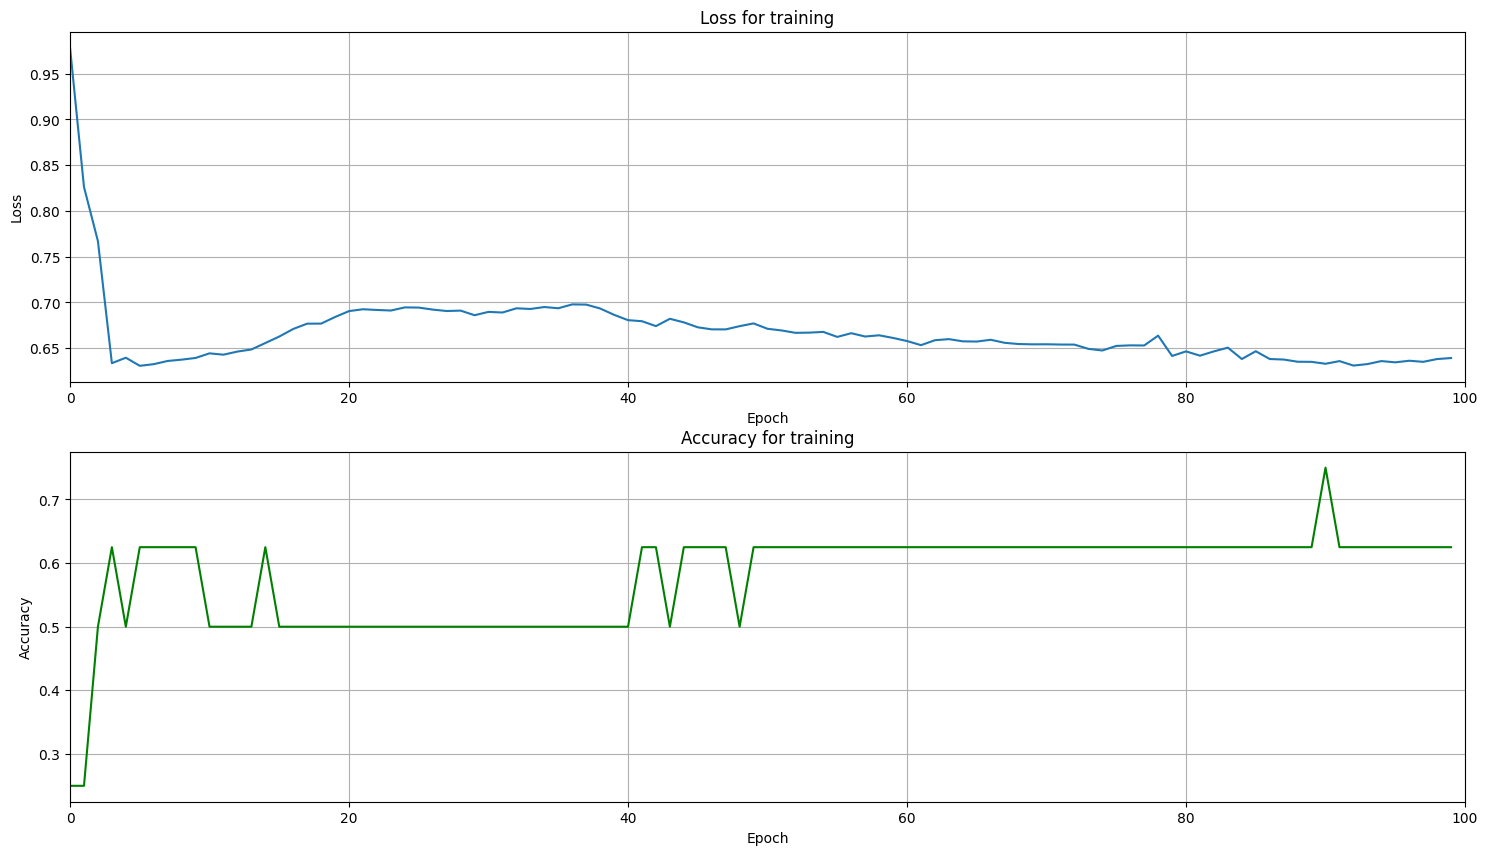

In [13]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_train)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([0,100])
plt.title('Loss for training')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(accuracy, c='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim([0,100])
plt.title('Accuracy for training')
plt.grid(True)
plt.show()
plt.close()

## Evaluation du modèle

Le modèle entrainé doit être évalué. Dans un premier temps nous utiliserons l'accuracy et dans un second temps nous allons contruire une matrice de confusion.

In [14]:
with torch.no_grad():
    predictions = (model(X_test) > 0.5).int()

accuracy = (predictions.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.739130437374115


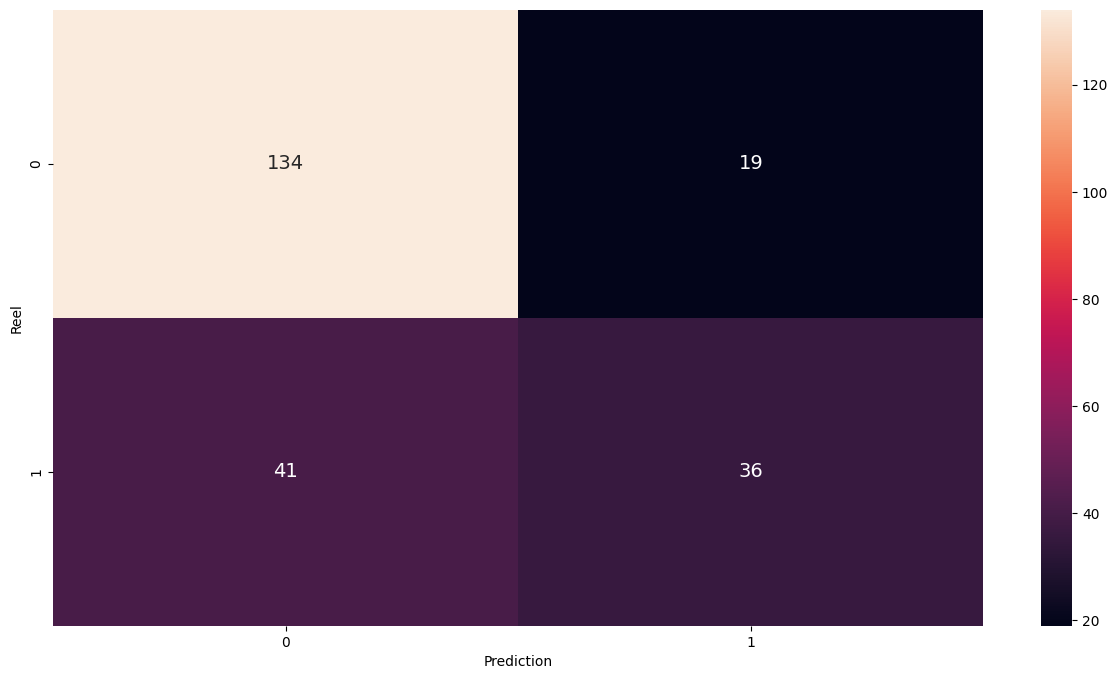

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Prediction')
plt.ylabel('Reel')
plt.show()

In [17]:
import datetime
torch.save(model, f"my_model{str(datetime.datetime.now())}.pickle")